## Семинар 3: "Методы оптимизации"

ФИО: Гасанов Марат Шамильевич

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from tqdm.auto import tqdm
from torch import nn
from matplotlib.pyplot import cm
from torchvision import datasets, transforms
%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [3]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths[0], weigths[1])
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [4]:
from matplotlib.colors import LogNorm


def compare_optimizers(
    fn,
    optim_list,
    start_point,
    x_range=(-5, 5),
    y_range=(-5, 5),
    xstep=0.2,
    ystep=0.2,
    minima=None,
    num_iter = 50,
):
    xmin, xmax = x_range
    ymin, ymax = y_range
    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = fn(torch.from_numpy(x), torch.from_numpy(y))
    z = z.detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
    if minima:
        ax.plot(*minima, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    colors = cm.rainbow(np.linspace(0, 1, len(optim_list)))

    for c, (name, optim, args) in zip(colors, optim_list):
        points, losses = optimize_function(fn, optim, args, start_point, num_iter)
        ax.quiver(
            points[:-1, 0], points[:-1, 1],
            points[1:, 0] - points[:-1, 0], points[1:, 1] - points[:-1, 1],
            scale_units='xy', angles='xy', scale=1, color=c,
            label=name
        )

    ax.legend()
    plt.show()



In [5]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


In [6]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in params]
        self.gamma = gamma

    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= self.lr * v



In [7]:
# v = gamma v - lr * dJ/dw (w - gamma * v)

class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.v = [torch.zeros_like(p) for p in params]
        self.gamma = gamma

    def pre_step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                p -= self.gamma * v

    def step(self):
        with torch.no_grad():
            for v, p in zip(self.v, self.params):
                if p.grad is None:
                    continue
                p += self.gamma * v
                v.copy_(self.gamma * v + self.lr * p.grad)
                p -= v



In [8]:
class RMSProp(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9, eps=1e-9):
        super().__init__(params)
        self.lr = lr
        self.G = [torch.zeros_like(p) for p in params]
        self.gamma = gamma
        self.eps = eps

    def step(self):
        with torch.no_grad():
            for g, p in zip(self.G, self.params):
                if p.grad is None:
                    continue
                g.copy_(self.gamma * g + (1 - self.gamma) * p.grad**2)
                p -= self.lr / torch.sqrt(g + self.eps) * p.grad



<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [9]:
def F1(x, y):
    return x**2 + y**2

def F2(x, y):
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [10]:
from torch.optim import SGD as torchSGD

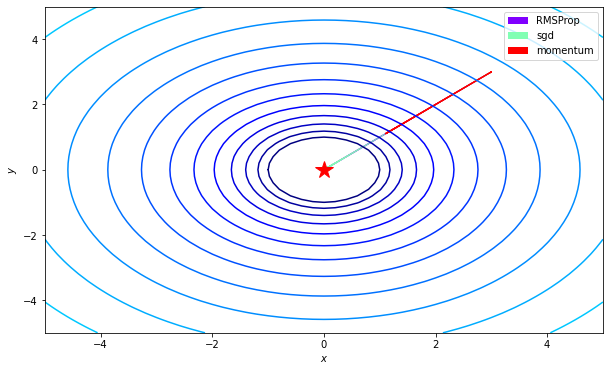

In [11]:
compare_optimizers(
    F1,
    [
        ('RMSProp', RMSProp, {}),
        ('sgd', SGD, {'lr':1e-2}),
        ('momentum', Momentum, {'lr':1e-2}),
       # ('torch_sgd', torchSGD, {'lr': 1e-3, 'nesterov': True, 'momentum': 0.9})
    ],
    start_point=[3,3],
    minima=(0, 0),
    num_iter=500
)

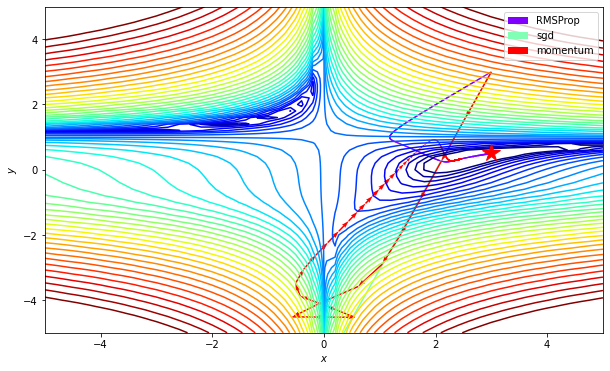

In [12]:
compare_optimizers(
    F2,
    [
        ('RMSProp', RMSProp, {}),
        ('sgd', SGD, {'lr':1e-2}),
        ('momentum', Momentum, {'lr':1e-2})
        #('torch_sgd', torchSGD, {'lr': 1e-3, 'nesterov': True, 'momentum': 0.9})
    ],
    start_point=[3,3],
    minima=(3, 0.5),
    num_iter=500
)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [13]:
def J_sin(x, y):
    return x*x*torch.sin(x) + y*y*torch.sin(y)

In [14]:
def J_sin_square(x, y):
    return x*x*torch.sin(x**2) + y*y*torch.sin(y**2)

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_37134/1872429200.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)


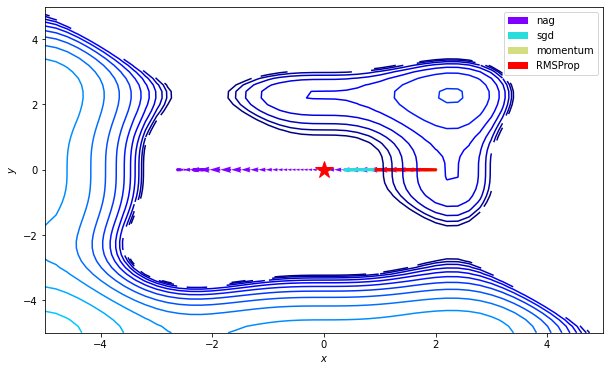

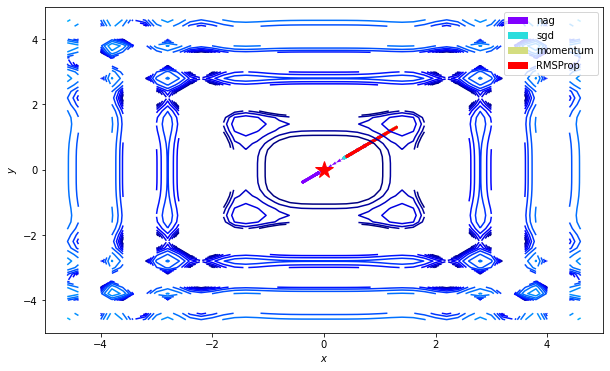

In [15]:
compare_optimizers(
    J_sin,
    [
        ('nag', NAG, {}),
        ('sgd', SGD, {}),
        ('momentum', Momentum, {}),
        ('RMSProp', RMSProp, {}),
    ],
    start_point=[2, 0],
    minima=(0, 0),
    num_iter=100
)

compare_optimizers(
    J_sin_square,
    [
        ('nag', NAG, {}),
        ('sgd', SGD, {}),
        ('momentum', Momentum, {}),
        ('RMSProp', RMSProp, {}),
    ],
    start_point=[1.3, 1.3],
    minima=(0, 0),
    num_iter=100
)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [16]:
class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon=1e-6):
        super().__init__(params)
        self.epsilon = epsilon
        self.lr = lr
        self.V = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for v, p in zip(self.V, self.params):
                if p.grad is None:
                    continue
                v.copy_(v + torch.square(p.grad))
                p -= self.lr*p.grad/torch.sqrt(v + self.epsilon)


In [17]:
from torch.optim import Adagrad as TAdagrad

In [18]:
class Adam(Optimizer):
    def __init__(self, params, lr=3*10**-4, epsilon=1e-9, beta1=0.9, beta2=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.M = [torch.zeros_like(p) for p in self.params]
        self.V = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for m, v, p in zip(self.M, self.V, self.params):
                if p.grad is None:
                    continue
                m.copy_(self.beta1*m + (1 - self.beta1)*p.grad)
                v.copy_(self.beta2*v + (1 - self.beta2)*torch.square(p.grad))
                m = m / (1- self.beta1)
                v = v / (1-self.beta2)
                p -= self.lr*m/torch.sqrt(v + self.epsilon)


In [19]:
from torch.optim import Adam as TAdam

In [ ]:
from torch.optim import Adadelta as tAdadelta
tAdadelta()

In [109]:
class Adadelta(Optimizer):
    def __init__(self, params, lr=1e-2, epsilon=1e-6, rho=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.lr = lr
        self.rho = rho
        self.delta_X = [torch.zeros_like(p) for p in self.params]
        self.S_t = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for p, delta_x, s_t in zip(self.params, self.delta_X, self.S_t):
                if p.grad is None:
                    continue
                s_t.copy_(self.rho*s_t + (1-self.rho)*p.grad**2)
                grad_stroke = torch.sqrt(delta_x + self.epsilon)/torch.sqrt(s_t+self.epsilon) * p.grad
                p -= grad_stroke
                delta_x.copy_(self.rho*delta_x - (1 - self.rho)*grad_stroke**2)

In [264]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2022-10-07 18:10:02--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-10-07 18:10:02--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [             <=>    ] 455.04K   167KB/s               ^C
x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-ubyte
x MNIST/raw/train-images-idx3-ubyte.gz
x MNIST/processed/
x

In [21]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [22]:
from torch.nn import Tanh
from torch.nn.functional import log_softmax

In [ ]:
class FCNet(nn.Module):
    def __init__(self, input_size=784, hidden_size=100, output_size=10):
        super(FCNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = log_softmax(x)
        return x



In [65]:
from IPython.core.display import clear_output

loss_log = []

def fit(nn, loss, train_loader, test_loader, optimizer, n_epoch=50, learning_rate=0.01, plot=True):
    train_losses = []
    test_losses = []
    for i in tqdm(range(n_epoch)):
        curr_losses = []
        curr_losses_test = []
        for X, y in tqdm(train_loader):
            X = X.view(X.shape[0], -1)
            optimizer.zero_grad()
            pred = nn(X)
            loss_ = loss(pred, y)
            loss_.backward()
            optimizer.step()
            curr_losses.append(loss_.item())

        train_losses.append(np.mean(curr_losses))
        for X_test, y_test in test_loader:
            X_test = X_test.view(X_test.shape[0], -1)
            pred = nn(X_test)
            loss_ = loss(pred, y_test)
            curr_losses_test.append(loss_.item())
        test_losses.append(np.mean(curr_losses_test))
        clear_output(True)
        print(f'epoch = {i},loss_item {train_losses[-1]}s')
    if plot:
        plt.plot(train_losses)
        plt.title("train")
        plt.grid('on')
        plt.show()
        plt.plot(test_losses)
        plt.title("test")
        plt.grid('on')
        plt.show()
    return train_losses, test_losses

In [90]:
model = FCNet()
loss_func = nn.CrossEntropyLoss()
optimizer_adagrad = Adagrad(model.parameters())
tr_adagrad, ts_adagrad = fit(nn=model, loss=loss_func, optimizer=optimizer_adagrad, train_loader=train_loader, test_loader=test_loader, n_epoch=10, plot=False)

epoch = 9,loss_item 0.07380194239442547s


In [91]:
model = FCNet()
loss_func = nn.CrossEntropyLoss()
optimizer_adam = Adam(model.parameters())
tr_adam, ts_adam  = fit(nn=model, loss=loss_func, optimizer=optimizer_adam, train_loader=train_loader, test_loader=test_loader, n_epoch=10, plot=False)

epoch = 9,loss_item 0.035014225680885525s


In [110]:
model = FCNet()
loss_func = nn.CrossEntropyLoss()
optimizer_adadelta = Adadelta(model.parameters())
tr_adadelta, ts_adadelta = fit(nn=model, loss=loss_func, optimizer=optimizer_adadelta, train_loader=train_loader, test_loader=test_loader, n_epoch=10, plot=False)

epoch = 9,loss_item 0.03253093255649631s


In [92]:
model = FCNet()
loss_func = nn.CrossEntropyLoss()
optimizer_sgd = SGD(model.parameters())
tr_sgd, ts_sgd = fit(model, loss_func, train_loader, test_loader, optimizer_sgd, n_epoch=10, plot=False)

epoch = 9,loss_item 0.1060507427384456s


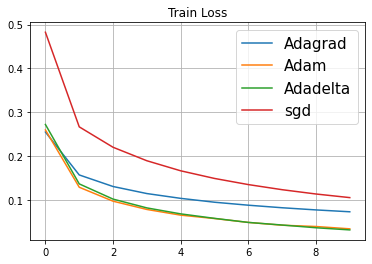

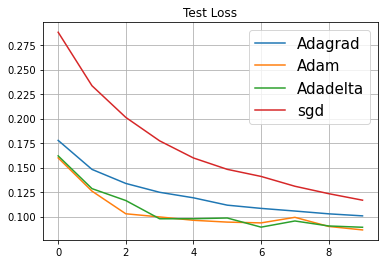

In [111]:
plt.plot(tr_adagrad, label='Adagrad')
plt.plot(tr_adam, label='Adam')
plt.plot(tr_adadelta, label='Adadelta')
plt.plot(tr_sgd, label='sgd')
plt.grid('on')
plt.title('Train Loss')
plt.legend(fontsize=15)
plt.show()

plt.plot(ts_adagrad, label='Adagrad')
plt.plot(ts_adam, label='Adam')
plt.plot(ts_adadelta, label='Adadelta')
plt.plot(ts_sgd, label='sgd')
plt.grid('on')
plt.legend(fontsize=15)
plt.title('Test Loss')
plt.show()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [37]:
import torch.nn.functional as F

In [76]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), stride=(1, 1), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        # fully connected layer, output 10 classes
        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 300),
            nn.ReLU(),
            nn.Linear(300, 10),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output


In [77]:
from torch.autograd import Variable
def train(num_epochs, cnn, loss_func, train_loader, test_loader, optimizer):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        current_losses = []
        for (images, labels) in tqdm((train_loader)):
            optimizer.zero_grad()
            output = cnn(images)
            loss = loss_func(output, labels)
            loss.backward()
            current_losses.append(loss.item())
            optimizer.step()
        train_losses.append(np.mean(current_losses))
        current_losses = []

        for i, (images, labels) in enumerate(test_loader):
            output = cnn(images)
            loss = loss_func(output, labels)
            current_losses.append(loss.item())
        test_losses.append(np.mean(current_losses))
        clear_output(True)
        print(f'epoch = {epoch},loss_item {test_losses[-1]}')

    return train_losses, test_losses

In [83]:
model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer_adagrad = Adagrad(model.parameters())
tr_adagrad_conv, ts_adagrad_conv = train(cnn=model, loss_func=loss_func, optimizer=optimizer_adagrad, train_loader=train_loader, test_loader=test_loader, num_epochs=6)

epoch = 5,loss_item 0.02590287140036019


In [84]:
model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer_adam = Adam(model.parameters())
tr_adam_conv, ts_adam_conv  = train(cnn=model, loss_func=loss_func, optimizer=optimizer_adam, train_loader=train_loader, test_loader=test_loader, num_epochs=6)

epoch = 5,loss_item 0.04012629670809236


In [113]:
model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer_adadelta = Adadelta(model.parameters())
tr_adadelta_conv, ts_adadelta_conv = train(cnn=model, loss_func=loss_func, optimizer=optimizer_adadelta, train_loader=train_loader, test_loader=test_loader, num_epochs=6)

epoch = 5,loss_item 0.03389188043473714


In [87]:
model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer_sgd = SGD(model.parameters())
tr_sgd_conv, ts_sgd_conv = train(cnn=model, loss_func=loss_func, optimizer=optimizer_sgd, train_loader=train_loader, test_loader=test_loader, num_epochs=6)

epoch = 5,loss_item 0.031231595554758018


### Сравним качество на Полносвзяной и сверточной сети

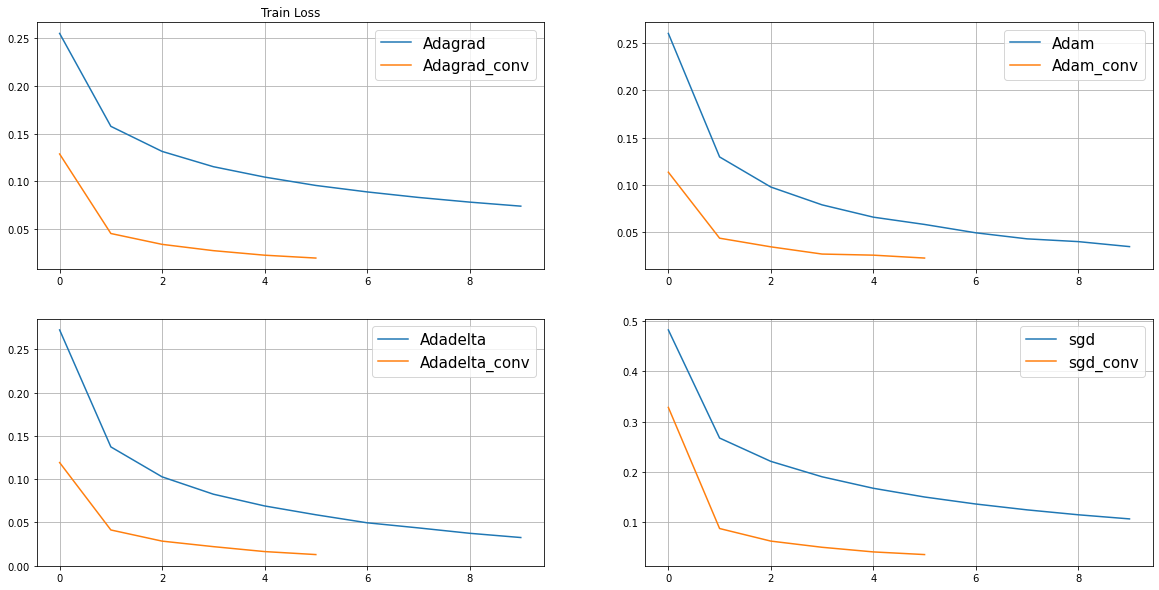

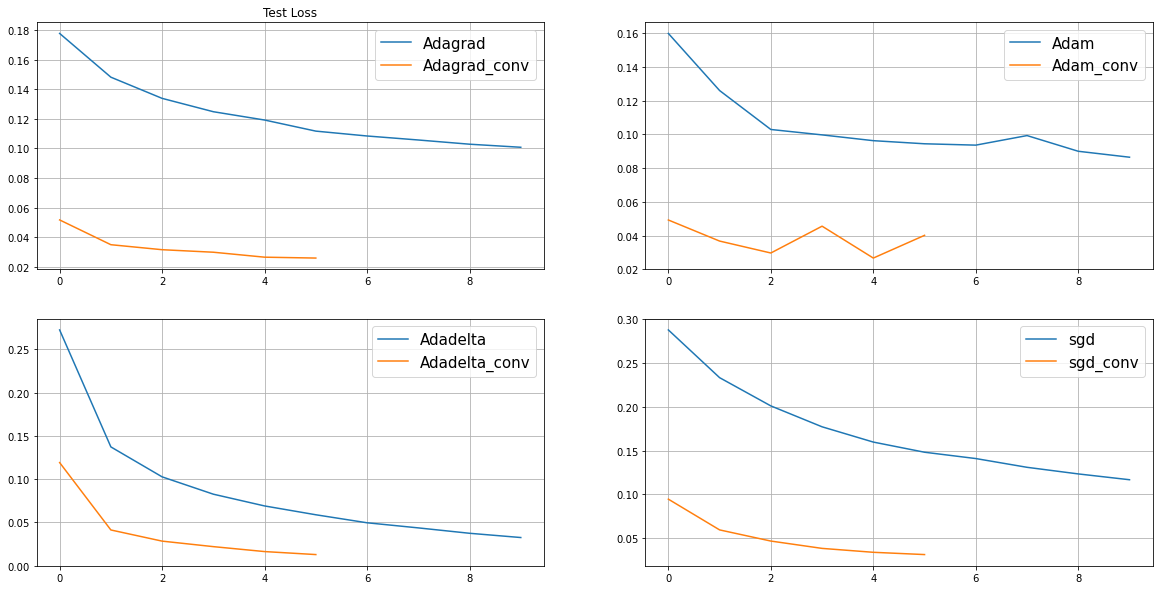

In [119]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(tr_adagrad, label='Adagrad')
plt.plot(tr_adagrad_conv, label='Adagrad_conv')
plt.grid('on')
plt.title('Train Loss')
plt.legend(fontsize=15)

plt.subplot(2, 2, 2)
plt.plot(tr_adam, label='Adam')
plt.plot(tr_adam_conv, label='Adam_conv')
plt.grid('on')
plt.legend(fontsize=15)

plt.subplot(2, 2, 3)
plt.plot(tr_adadelta, label='Adadelta')
plt.plot(tr_adadelta_conv, label='Adadelta_conv')
plt.grid('on')
plt.legend(fontsize=15)

plt.subplot(2, 2, 4)
plt.plot(tr_sgd, label='sgd')
plt.plot(tr_sgd_conv, label='sgd_conv')

plt.grid('on')
plt.legend(fontsize=15)
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(ts_adagrad, label='Adagrad')
plt.plot(ts_adagrad_conv, label='Adagrad_conv')
plt.grid('on')
plt.title('Test Loss')
plt.legend(fontsize=15)

plt.subplot(2, 2, 2)
plt.plot(ts_adam, label='Adam')
plt.plot(ts_adam_conv, label='Adam_conv')
plt.grid('on')
plt.legend(fontsize=15)

plt.subplot(2, 2, 3)
plt.plot(tr_adadelta, label='Adadelta')
plt.plot(tr_adadelta_conv, label='Adadelta_conv')
plt.grid('on')
plt.legend(fontsize=15)

plt.subplot(2, 2, 4)
plt.plot(ts_sgd, label='sgd')
plt.plot(ts_sgd_conv, label='sgd_conv')
plt.grid('on')
plt.legend(fontsize=15)
plt.show()

## Как мы видим сверточные нейронные сети работают лучше полносвязных на задачах распознавания изображений

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

In [1]:
import numpy as np
import pandas as pd


In [6]:
def make_test_data(random_seed: int, number_elements: int) -> np.ndarray:
    np.random.seed(random_seed)
    dataset = np.array([
        np.random.randint(20, 90, number_elements),  # age between 20 and 90
        np.random.randint(0, 2, number_elements),  # sex 1-M 0-F
        np.random.randint(0, 4, number_elements),  # cp: chest pain
        np.random.randint(100, 150, number_elements),  # trestbps
        np.random.randint(250, 350, number_elements),  # chol
        np.random.randint(0, 2, number_elements),  # fbs
        np.random.randint(0, 3, number_elements),  # restecg
        np.random.randint(100, 200, number_elements),  # thalach
        np.random.randint(0, 2, number_elements),  # exang
        np.random.rand(0, 5, number_elements),  # oldpeak
        np.random.randint(0, 3, number_elements),  # slope
        np.random.randint(0, 4, number_elements),  # ca
        np.random.randint(0, 3, number_elements),  # thal
        np.random.randint(0, 2, number_elements)  # condition
    ])
    dataset = np.array([
        np.array(np.random.randint(20, 90, number_elements)),  # age between 20 and 90
        np.array(np.random.randint(0, 2, number_elements))  # sex 1-M 0-F
    ])
    return dataset.T

In [7]:
make_test_data(20, 10)

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_67081/2399039894.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array([


array([[45,  1],
       [61,  0],
       [29,  0],
       [86,  0],
       [35,  1],
       [85,  0],
       [50,  1],
       [69,  0],
       [60,  1],
       [31,  1]])

In [1]:
import numpy as np
import pandas as pd

In [21]:
def make_dataframe(random_seed: int, number_elements: int) -> pd.DataFrame:
    np.random.seed(random_seed)

    age = pd.Series(np.random.randint(20, 90, number_elements))  # age between 20 and 90
    sex = pd.Series(np.random.randint(0, 2, number_elements))  # sex 1-M 0-F
    cp = pd.Series(np.random.randint(0, 4, number_elements))  # cp: chest pain
    trestbps = pd.Series(np.random.randint(100, 150, number_elements))  # trestbps
    chol = pd.Series(np.random.randint(250, 350, number_elements))  # chol
    fbs = pd.Series(np.random.randint(0, 2, number_elements))  # fbs
    restecq = pd.Series(np.random.randint(0, 3, number_elements))  # restecg
    thalach = pd.Series(np.random.randint(100, 200, number_elements))  # thalach
    exang = pd.Series(np.random.randint(0, 2, number_elements))  # exang
    oldpeak = pd.Series(np.random.random(number_elements)+np.random.randint(0,5, number_elements))  # oldpeak
    slope = pd.Series(np.random.randint(0, 3, number_elements))  # slope
    ca = pd.Series(np.random.randint(0, 4, number_elements))  # ca
    thal = pd.Series(np.random.randint(0, 3, number_elements))  # thal
    condition = pd.Series(np.random.randint(0, 2, number_elements)) # condition

    df_dict = {
        'age': age, 'sex': sex, 'cp': cp, 'trestbps': trestbps, 'chol': chol, 'fbs': fbs, 'restecq': restecq, 'thalach': thalach,
        'exang': exang, 'oldpeak': oldpeak, 'slope': slope, 'ca': ca, 'thal': thal, 'condition': condition
    }
    df = pd.DataFrame(df_dict)
    return df

In [22]:
make_dataframe(10, 10)

,age,sex,cp,trestbps,chol,fbs,restecq,thalach,exang,oldpeak,slope,ca,thal,condition
0,29,0,0,113,277,0,2,171,1,2.944261,1,1,1,1
1,35,1,2,128,268,1,0,188,0,3.987625,1,2,1,0
2,84,1,1,122,343,1,1,188,0,0.456305,2,0,0,1
3,48,0,3,130,327,0,0,150,1,4.826123,0,2,0,1
4,49,0,2,130,272,0,2,154,0,2.251374,2,2,0,1
5,28,1,1,125,273,0,0,134,0,0.597372,1,1,2,0
6,20,0,1,112,344,1,0,115,1,3.902832,0,1,2,0
7,60,0,1,101,261,0,0,177,0,3.534558,1,0,2,0
8,56,1,3,131,278,1,1,188,0,1.590201,1,0,0,1
9,36,0,1,136,324,1,0,115,0,2.039282,0,0,2,0


In [18]:
np.random.ra

TypeError: random() takes at most 1 positional argument (2 given)